In [1]:
import numpy as np
from numpy import where, dstack, diff, meshgrid
import xarray as xr
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def find_intersections(A, B):

    # min, max and all for arrays
    amin = lambda x1, x2: where(x1<x2, x1, x2)
    amax = lambda x1, x2: where(x1>x2, x1, x2)
    aall = lambda abools: dstack(abools).all(axis=2)
    slope = lambda line: (lambda d: d[:,1]/d[:,0])(diff(line, axis=0))

    x11, x21 = meshgrid(A[:-1, 0], B[:-1, 0])
    x12, x22 = meshgrid(A[1:, 0], B[1:, 0])
    y11, y21 = meshgrid(A[:-1, 1], B[:-1, 1])
    y12, y22 = meshgrid(A[1:, 1], B[1:, 1])

    m1, m2 = meshgrid(slope(A), slope(B))
    m1inv, m2inv = 1/m1, 1/m2

    yi = (m1*(x21-x11-m2inv*y21) + y11)/(1 - m1*m2inv)
    xi = (yi - y21)*m2inv + x21

    xconds = (amin(x11, x12) < xi, xi <= amax(x11, x12), 
              amin(x21, x22) < xi, xi <= amax(x21, x22) )
    yconds = (amin(y11, y12) < yi, yi <= amax(y11, y12),
              amin(y21, y22) < yi, yi <= amax(y21, y22) )

    return xi[aall(xconds)], yi[aall(yconds)]

In [4]:
def NASHWR(ds):

    xnash_list=[]
    ynash_list=[]
    
    ds_amp=ds.sel(lat=slice(45,20),lon=slice(280,350)).max(dim=['lat','lon'])
    
    for t in ds['time'].values:
        
        ds_tmp=ds.sel(time=t)
        
        da_diff=ds_tmp['u850'].differentiate(coord='lat')
        cs1=plt.contour(ds['lon'],ds['lat'],ds_tmp['z850'],[1560],linestyle='None',colors='white')
        cs2=plt.contour(ds['lon'],ds['lat'],ds_tmp['u850'],[0],linestyle='None',colors='white')
    
        x_list=[]
        y_list=[]
        for p1 in cs1.collections[0].get_paths():
            v1=p1.vertices
            #plt.plot(v1[:,0],v1[:,1],color='k')
            for p2 in cs2.collections[0].get_paths():
                v2=p2.vertices
                x2=v2[:,0]
                y2=v2[:,1]
                x,y = find_intersections(v1,v2)
                if (len(x)!=0):
                    #plt.plot(x2,y2,color='g',marker='x')
                    #plt.plot(x,y,marker='.',linestyle='None',color='b',markersize=10)
                    x_list=np.append(x_list,x)    
                    y_list=np.append(y_list,y)
        
        # If we identified an intersection
        if (len(x_list)>0):
            
            # If there is more than one intersection, pick the western-most one
            if len(x_list)>1:
                idx=np.argmin(x_list)
                x_nash=x_list[idx]
                y_nash=y_list[idx]
                
                # Check for positive vorticity
                vort=da_diff.sel(lon=x_nash,lat=y_nash,method='nearest')
                if (vort<=0):
                    x_nash=np.nan
                    y_nash=np.nan  
            # Pick the one we have
            else:
                x_nash=x_list[0]
                y_nash=y_list[0]
                
                # Check for positive vorticity
                vort=da_diff.sel(lon=x_nash,lat=y_nash,method='nearest')
                if (vort<=0):
                    x_nash=np.nan
                    y_nash=np.nan  
                    
        # No intersection, set to nan
        else:
            x_nash=np.nan
            y_nash=np.nan
        
        #plt.plot(x_nash,y_nash,marker='.',linestyle='None',color='r',markersize=10)
        #print(t,x_nash,y_nash)
        
        # Append to list for this time
        xnash_list=np.append(xnash_list,x_nash)
        ynash_list=np.append(ynash_list,y_nash)
        
    # Make dataset    
    ds1=xr.DataArray(ynash_list,coords={'time':ds['time']},dims=['time']).to_dataset(name='lats')
    ds2=xr.DataArray(xnash_list,coords={'time':ds['time']},dims=['time']).to_dataset(name='lons')
    ds3=xr.DataArray(ds_amp['z850'].values,coords={'time':ds['time']},dims=['time']).to_dataset(name='amp')
    ds_nash=xr.merge([ds1,ds2,ds3])
        
    return ds_nash

In [5]:
in_path='/project/predictability/kpegion/wxregimes/era-interim/'
infname='erai.z850_u850_nash_1997-2015.nc'

In [6]:
lons=[240,360]
lats=[0,60]
lon_0=np.floor((lons[1]-lons[0])*0.5)
winter=[12,1,2]
summer=[6,7,8]
nash_climo=[274.0,27]

In [7]:
ds=xr.open_dataset(in_path+infname)
ds['z850']=ds['z850']/9.81
ds

<xarray.Dataset>
Dimensions:  (lat: 86, lon: 170, time: 6939)
Coordinates:
  * lat      (lat) float64 60.0 59.3 58.6 57.89 ... 2.456 1.754 1.053 0.3509
  * lon      (lon) float64 240.5 241.2 241.9 242.6 ... 357.2 357.9 358.6 359.3
  * time     (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2015-12-31
Data variables:
    z850     (time, lat, lon) float32 1.29e+03 1.294e+03 ... 1.538e+03 1.537e+03
    u850     (time, lat, lon) float32 ...

In [8]:
ds_rmmean=ds.rolling(time=5,center=True).mean().dropna(dim='time')

<xarray.Dataset>
Dimensions:  (time: 1748)
Coordinates:
  * time     (time) datetime64[ns] 1997-06-01 1997-06-02 ... 2015-08-31
Data variables:
    lats     (time) float64 34.27 29.48 27.64 26.3 ... 29.31 36.82 37.49 38.22
    lons     (time) float64 292.8 294.8 297.8 300.2 ... 283.9 279.1 276.3 274.3
    amp      (time) float64 1.594e+03 1.586e+03 1.58e+03 ... 1.593e+03 1.596e+03

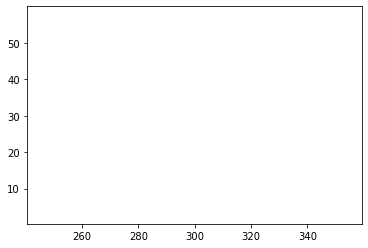

In [9]:
ds_jja=ds_rmmean.sel(time=ds_rmmean['time.month'].isin([summer])).dropna(dim='time')
ds_nash=NASHWR(ds_jja)
ds_nash

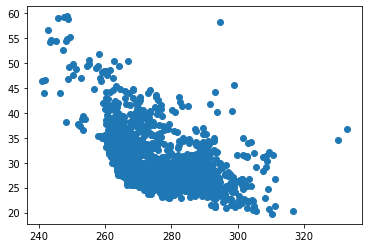

In [10]:
plt.scatter(ds_nash['lons'],ds_nash['lats'])

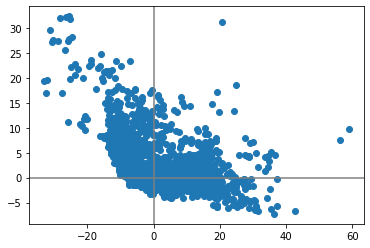

In [11]:
nash_diff=[ds_nash['lons']-nash_climo[0],ds_nash['lats']-nash_climo[1]]
plt.scatter(nash_diff[0],nash_diff[1])
plt.axhline(y=0, color='gray')
plt.axvline(x=0, color='gray')

In [12]:
nash_phase = np.floor((np.rad2deg(np.arctan2(nash_diff[1],nash_diff[0]))+180.0)/90.0)
ds_phase=xr.DataArray(nash_phase,coords={'time':ds_nash['time']},dims=['time']).to_dataset(name='phase')
ds_amp=ds_jja['z850'].sel(lat=slice(40,20),lon=slice(280,350)).max(dim=['lat','lon']).to_dataset(name='amp')

In [13]:
nash_phase[23].values
print(nash_diff[0][23].values)

nan


In [ ]:
outfile='/scratch/kpegion/ERAI_NASH_JJA.1997-2015.nc'
xr.merge([ds_phase,ds_amp]).to_netcdf(outfile)